In [1]:
from cil.optimisation.operators import MatrixOperator
from cil.optimisation.functions import LeastSquares, ZeroFunction, SGDFunction
from cil.framework import VectorData
from cil.optimisation.algorithms import ISTA, FISTA, GD
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_subsets = 10

We solve the following problem with the GD and FISTA algorithms.

$$ \underset{x}{\mathrm{argmin}} \frac{1}{2n}\|A x - b\|^{2} $$

In [3]:
np.random.seed(10)
n = 50
m = 500

A = np.random.uniform(0,1, (m, n)).astype('float32')
b = (A.dot(np.random.randn(n)) + 0.1*np.random.randn(m)).astype('float32')

Aop = MatrixOperator(A)
bop = VectorData(b) 

f = LeastSquares(Aop, b=bop, c = 0.5/n_subsets) 
g = ZeroFunction()

ig = Aop.domain

initial = ig.allocate()

In [4]:
## GD algorithm
step_size = 2*0.99/f.L
gd = GD(initial = initial, objective_function = f, step_size = step_size,
        max_iteration=100, 
        update_objective_interval=1)
gd.run(verbose=0)

In [5]:
## FISTA algorithm
fista = FISTA(initial = initial, f = f, g = ZeroFunction(),
        max_iteration=100, 
        update_objective_interval=1)
fista.run(verbose=0)

In [6]:
## Using CVXpy
import cvxpy
u_cvxpy = cvxpy.Variable(ig.shape[0])
objective = cvxpy.Minimize( 0.5/n_subsets * cvxpy.sum_squares(Aop.A @ u_cvxpy - bop.array))
p = cvxpy.Problem(objective)
p.solve(verbose=True, solver=cvxpy.SCS, eps=1e-4)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 18 02:58:21 PM: Your problem has 50 variables, 0 constraints, and 0 parameters.
(CVXPY) Aug 18 02:58:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 18 02:58:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 18 02:58:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 18 02:58:21 PM: Compiling problem (target solver=SCS).
(CVXPY) Aug 18 02:58:21 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> 

0.21832297384356078

In [7]:
print("GD objective = {}".format(gd.objective[-1]))
print("FISTA objective = {}".format(fista.objective[-1]))
print("CVX objective = {}".format(objective.value))

GD objective = 8.689764404296875
FISTA objective = 0.3137732028961182
CVX objective = 0.21832297384356078


We solve the following problem  

$$ \underset{x}{\mathrm{argmin}} \,\big\{ f(x) = \frac{1}{n}\sum_{i=1}^{n}f_{i}(x) \big\}, \mbox{ with } f_{i}(x)=\frac{1}{2}\|A_{i}x - b_{i}\|^{2} $$

with
- Stochostic Gradient Descent (SGD) algorithm :  GD + SGDFunction
- Stochastic FISTA algorithm :  FISTA + SGDFunction




In [8]:
Ai = np.vsplit(A, n_subsets) 
bi = [b[i:i+n] for i in range(0, m, n)]     

fi_cil = []
for i in range(n_subsets):   
    Ai_cil = MatrixOperator(Ai[i])
    bi_cil = VectorData(bi[i])
    fi_cil.append(LeastSquares(Ai_cil, bi_cil, c = 0.5))
    
F_SGD = SGDFunction(fi_cil, replacement="False")    

In [9]:
epochs = 100

In [10]:
step_size = 2*0.99/f.L
sgd = GD(initial = initial, objective_function = F_SGD, step_size = step_size,
        max_iteration=epochs*n_subsets, 
        update_objective_interval=n_subsets)
sgd.run(verbose=0)

In [11]:
s_fista = FISTA(initial = initial, f = F_SGD, g = ZeroFunction(),
        max_iteration=epochs*n_subsets, 
        update_objective_interval=n_subsets)
s_fista.run(verbose=0)

In [12]:
print(s_fista.objective[-1])
print(fista.objective[-1])
print(gd.objective[-1])
print(sgd.objective[-1])
print(objective.value)

0.2561312809586525
0.3137732028961182
8.689764404296875
0.6484212368726731
0.21832297384356078


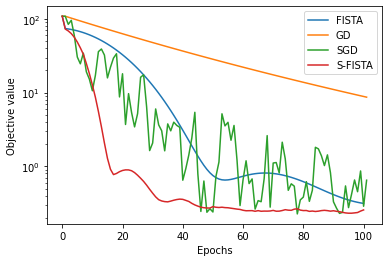

In [13]:
plt.figure()
plt.semilogy(fista.objective, label="FISTA")
plt.semilogy(gd.objective, label="GD")
plt.semilogy(sgd.objective, label="SGD")
plt.semilogy(s_fista.objective, label="S-FISTA")
plt.ylabel("Objective value")
plt.xlabel("Epochs")
plt.legend()
plt.show()

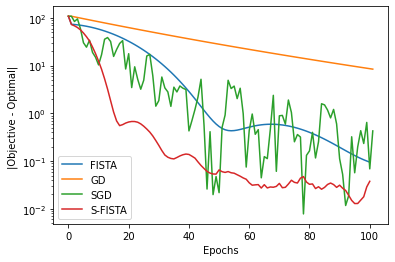

In [14]:
plt.figure()
plt.semilogy([np.abs(objective.value - i) for i in fista.objective], label="FISTA")
plt.semilogy([np.abs(objective.value - i) for i in gd.objective], label="GD")
plt.semilogy([np.abs(objective.value - i) for i in sgd.objective], label="SGD")
plt.semilogy([np.abs(objective.value - i) for i in s_fista.objective], label="S-FISTA")
plt.ylabel("|Objective - Optimal| ")
plt.xlabel("Epochs")
plt.legend()
plt.show()

We solve 

$$ \underset{x>0}{\mathrm{argmin}}\, \alpha\,\mathrm{TV}(x) + \|A x - b\|^{2} $$

$$ \underset{x>0}{\mathrm{argmin}}\, \alpha\,\mathrm{TV}(x) + \sum_{i=1}^{n}\|A_{i} x - b_{i}\|^{2} $$

In [15]:
from cil.framework import  AcquisitionGeometry
from cil.plugins import TomoPhantom
from cil.plugins.astra.operators import ProjectionOperator
from cil.processors import Slicer
from cil.optimisation.functions import LeastSquares, IndicatorBox, ZeroFunction, TotalVariation
from cil.optimisation.algorithms import ISTA, GD
from cil.utilities.display import show2D

In [16]:
# code from https://github.com/vais-ral/CCPi-Users-QMUL/blob/3de563276c169f298cdd9ce48f3e4a98800ca33a/SPDHG/QM_SPDHG_explicit.py#L114

import numpy as np
class AcquisitionGeometrySubsetGenerator(object):
    '''AcquisitionGeometrySubsetGenerator is a factory that helps generating subsets of AcquisitionData
    
    AcquisitionGeometrySubsetGenerator generates the indices to slice the data array in AcquisitionData along the 
    angle dimension with 4 methods:
    1. random: picks randomly between all the angles. Subset may contain same projection as other
    2. random_permutation: generates a number of subset by a random permutation of the indices, thereby no subset contain the same data.
    3. uniform: divides the angles in uniform subsets without permutation
    4. stagger: generates number_of_subsets by interleaving them, e.g. generating 2 subsets from [0,1,2,3] would lead to [0,2] and [1,3]
    The factory is not to be used directly rather from the AcquisitionGeometry class.
    '''
    
    ### Changes in the Operator required to work as OS operator
    @staticmethod
    def generate_subset(acquisition_data, number_of_subsets, method='random'):
        
        ag = acquisition_data.geometry
        angles = ag.angles.copy()
        if method == 'random':
            indices = [ AcquisitionGeometrySubsetGenerator.random_indices(angles, number_of_subsets) 
              for _ in range(number_of_subsets) ] 
            
        elif method == 'random_permutation':
            rndidx = np.asarray(range(len(angles)))
            np.random.shuffle(rndidx)
            indices = AcquisitionGeometrySubsetGenerator.uniform_groups_indices(rndidx, number_of_subsets)
            
        elif method == 'uniform':
            rndidx = np.asarray(range(len(angles)))
            indices = AcquisitionGeometrySubsetGenerator.uniform_groups_indices(rndidx, number_of_subsets)
            
        elif method == 'stagger':
            idx = np.asarray(range(len(angles)))
            indices = AcquisitionGeometrySubsetGenerator.staggered_indices(idx, number_of_subsets)
        else:
            raise ValueError('Can only do {}. got {}'.format(['random', 'random_permutation', 'uniform'], method))
        
        # return indices    
        subsets = [] 
        for idx in indices:
            g = ag.copy()
            angles = ag.angles[idx]
            #preserve initial angle and unit
            g.config.angles.angle_data = angles
            data = g.allocate(0)
            data.fill(acquisition_data.as_array()[idx])
            subsets.append( data )
            
        return subsets, indices
    
    @staticmethod
    def uniform_groups_indices(idx, number_of_subsets):
        indices = []
        groups = int(len(idx)/number_of_subsets)
        for i in range(number_of_subsets):
            ret = np.asarray(np.zeros_like(idx), dtype=bool)
            for j,el in enumerate(idx[i*groups:(i+1)*groups]):
                ret[el] = True
                
            indices.append(ret)
        return indices
    @staticmethod
    def random_indices(angles, number_of_subsets):
        N = int(np.floor(float(len(angles))/float(number_of_subsets)))
        indices = np.asarray(range(len(angles)))
        np.random.shuffle(indices)
        indices = indices[:N]
        ret = np.asarray(np.zeros_like(angles), dtype=bool)
        for i,el in enumerate(indices):
            ret[el] = True
        return ret
    @staticmethod
    def staggered_indices(idx, number_of_subsets):
        indices = []
        # groups = int(len(idx)/number_of_subsets)
        for i in range(number_of_subsets):
            ret = np.asarray(np.zeros_like(idx), dtype=bool)
            indices.append(ret)
        i = 0
        while i < len(idx):    
            for ret in indices:
                ret[i] = True
                i += 1
                if i >= len(idx):
                    break
                
        return indices
    @staticmethod
    def get_new_indices(index):
        newidx = []
        for idx in index:
            ai = np.where(idx == True)[0]
            for i in ai:
                newidx.append(i)
        return np.asarray(newidx)

In [17]:
# Detectors
N = 128
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(-angles)\
                        .set_panel(detectors, pixel_size=0.1, origin="top-right")                        
# Get image geometry
ig = ag.get_ImageGeometry()

# # Get phantom
phantom = TomoPhantom.get_ImageData(12, ig)

# Create projection operator using Astra-Toolbox. Available CPU/CPU
device = 'cpu'
A = ProjectionOperator(ig, ag, device = device)

# Create an acqusition data (numerically)
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
gaussian_var = 0.5
gaussian_mean = 0

n1 = np.random.normal(gaussian_mean, gaussian_var, size = ag.shape)
                      
noisy_sino = ag.allocate()
noisy_sino.fill(n1 + sino.array)
noisy_sino.array[noisy_sino.array<0]=0

In [18]:
alpha = 0.5
G = alpha * TotalVariation(lower=0) 
F = LeastSquares(A, b = noisy_sino)
initial = ig.allocate(0)
ista = ISTA(initial=initial, f=F, g=G, update_objective_interval = 1, 
            max_iteration = 50)
ista.run(verbose=0)

In [19]:
# Define number of subsets
n_subsets = 10 # should be divisible with total number of angles?

sino_subsets,_ = AcquisitionGeometrySubsetGenerator.generate_subset(noisy_sino, n_subsets , method='stagger')
sino_subsets

f_subsets = []
A_subsets = []

for ss in sino_subsets:
    
    Ai = ProjectionOperator(ig, ss.geometry, device = device)
    A_subsets.append(Ai)
    fi = LeastSquares(Ai, b = ss)
    f_subsets.append(fi)    
    

In [20]:
# Define F, G and K
F_sgd1 = n_subsets * SGDFunction(f_subsets, sampling = "random", replacement=False) 
G = alpha * TotalVariation(lower=0)
num_epochs = 50

initial = ig.allocate(0)

s_ista1 = ISTA(initial=initial, 
            f=F_sgd1,
            g=G, update_objective_interval = n_subsets, 
            max_iteration = num_epochs * n_subsets)
s_ista1.run(verbose=0)

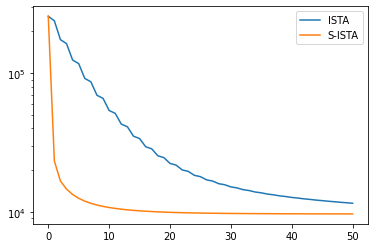

In [21]:
plt.figure()
plt.semilogy(ista.objective, label="ISTA")
plt.semilogy(s_ista1.objective, label="S-ISTA")
plt.legend()
plt.show()

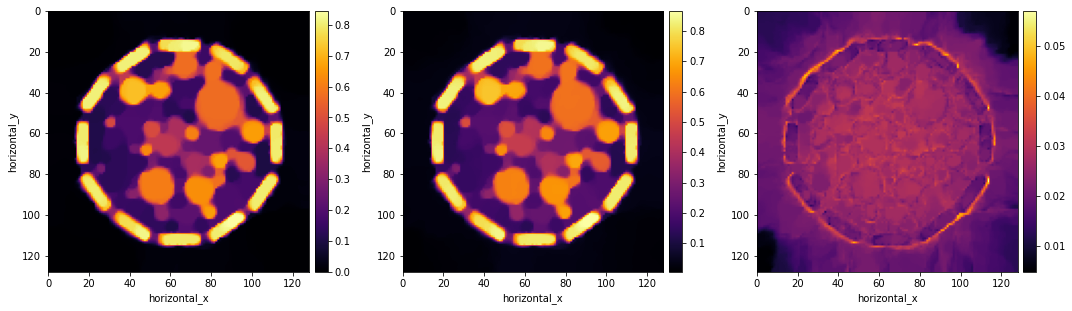

In [22]:
from cil.utilities.display import show2D
show2D([ista.solution, s_ista1.solution, (s_ista1.solution - ista.solution).abs()], num_cols=3, cmap="inferno", origin="upper")